# Vehicle Insurance Predictor
### Index : 
    1. Deep Exploratory Data Analysis
    2. Outlier Analysis
    3. Corelation Analysis
    4. Data Preprocessing
    5. Model Building
    6. Hyperparameter Tuning

# Importing Libraries

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualizatin
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
sns.set(style="ticks", context="talk")
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import optuna
from optuna.samplers import TPESampler


# Reading Data

In [8]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [9]:
print('Shape of train: {}'.format(train.shape))
print('Shape of test: {}'.format(test.shape))

Shape of train: (381109, 12)
Shape of test: (127037, 11)


In [10]:
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Data Dictionary

id:	Unique ID for the customer

Gender:	Gender of the customer

Age: Age of the customer

Driving_License: 	0 : Customer does not have DL, 1 : Customer already has DL

Region_Code:	Unique code for the region of the customer

Previously_Insured: 	1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

Vehicle_Age: 	Age of the Vehicle 

Vehicle_Damage: 
1 : Customer got his/her vehicle damaged in the past.
0 : Customer didn't get his/her vehicle damaged in the past.

Annual_Premium: The amount customer needs to pay as premium in the year

Policy_Sales_Channel:	Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

Vintage:	Number of Days, Customer has been associated with the company

Response:	1 :  Customer is interested, 0 : Customer is not interested

## Encoding Target Variable

In [11]:
train['Response'] = le.fit_transform(train['Response'])

# Exploratory Data Analysis

### Checking Target Variable Bias

<AxesSubplot:ylabel='Response'>

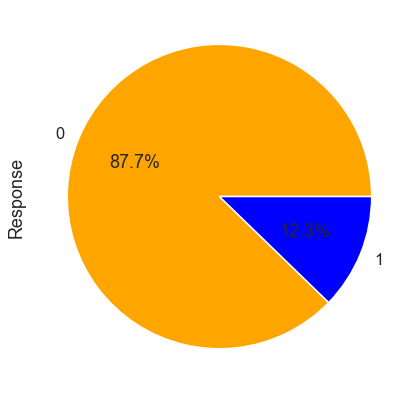

In [12]:
train['Response'].value_counts().plot.pie(autopct = '%1.1f%%',colors=['Orange','Blue'], figsize = (7,7))

## Data is Imbalanced. Only 12.3% of customers are likely to buy insuarance.

## Missing Value Analysis

In [13]:
train.isna().sum()/train.shape[0]*100

id                      0.0
Gender                  0.0
Age                     0.0
Driving_License         0.0
Region_Code             0.0
Previously_Insured      0.0
Vehicle_Age             0.0
Vehicle_Damage          0.0
Annual_Premium          0.0
Policy_Sales_Channel    0.0
Vintage                 0.0
Response                0.0
dtype: float64

There are no missing values

## Analysing Each Variable's Relationship with Target Variablem

### 1. Gender

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Gender', ylabel='count'>

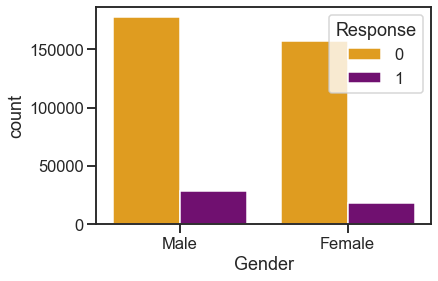

In [14]:
sns.countplot(train['Gender'], hue = train['Response'],palette=['Orange','Purple'])

## 2. Age

C:\Users\archa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Age'>

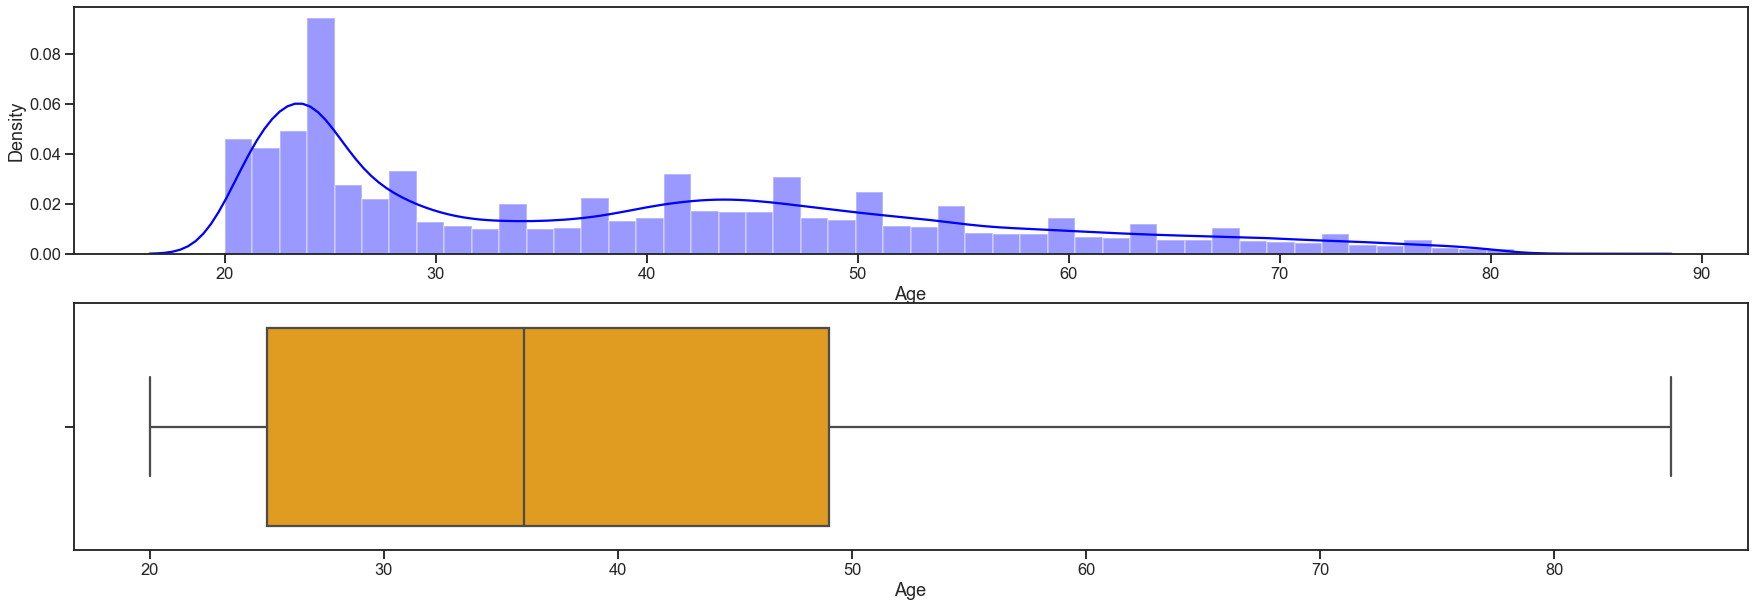

In [15]:
f,ax = plt.subplots(nrows=2,ncols=1,figsize=(30,10))
axx = ax.flatten()
#plt.figure(figsize=(30,10))
sns.distplot(train['Age'],ax=axx[0], color='Blue')
sns.boxplot(train['Age'],ax=axx[1],color='Orange')

### Analysing Response for different Age-Groups

In [16]:
age_grp_20_to_30 = train[ train['Age'] <31]
age_grp_31_to_40 = train[ train['Age'].between(31,40)]
age_grp_41_to_50 = train[ train['Age'].between(41,50)]
age_grp_50_to_60 = train[ train['Age'].between(51,60)]
age_grp_old = train[ train['Age'] >60]

age_grp = [age_grp_20_to_30,age_grp_31_to_40,age_grp_41_to_50,age_grp_50_to_60,age_grp_old]
age_grp_name = ['age_grp_20_to_30','age_grp_31_to_40','age_grp_41_to_50','age_grp_50_to_60','age_grp_old']
age_grp_dict = dict(zip(age_grp_name, age_grp))

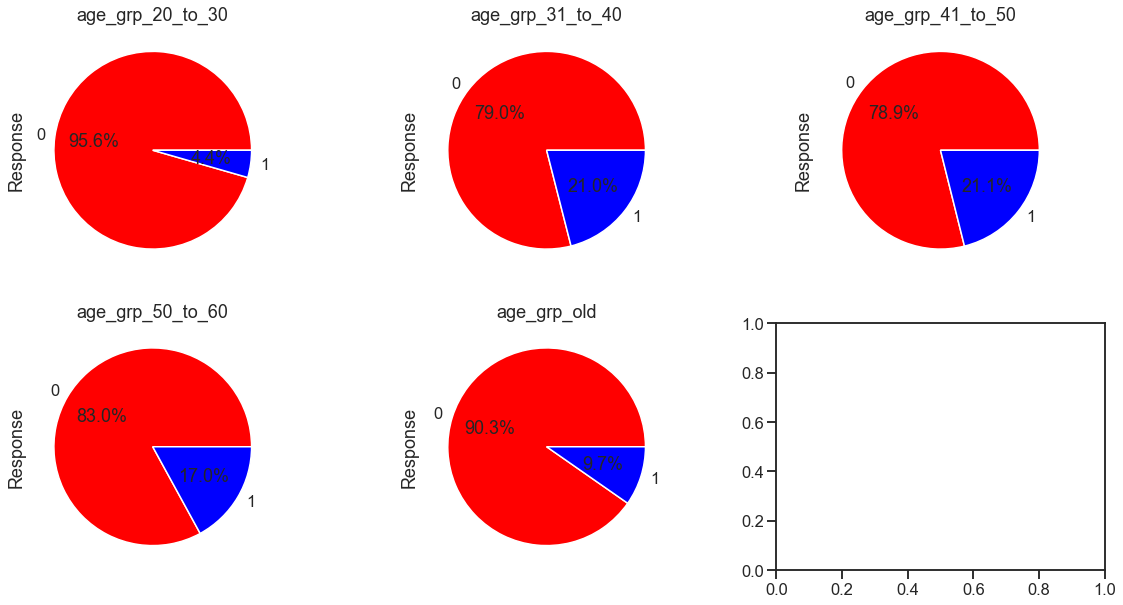

In [17]:
f,ax = plt.subplots(nrows=2, ncols=3, figsize = (20,10))
axx = ax.flatten()
for pos,tup in enumerate(age_grp_dict.items()):
    axx[pos].set_title(tup[0])
    data = tup[1]
    data['Response'].value_counts().plot.pie(autopct='%1.1f%%', ax = axx[pos],colors=['Red','Blue'])

### Analysing Response with both 'Age-Groups' and 'Gender'

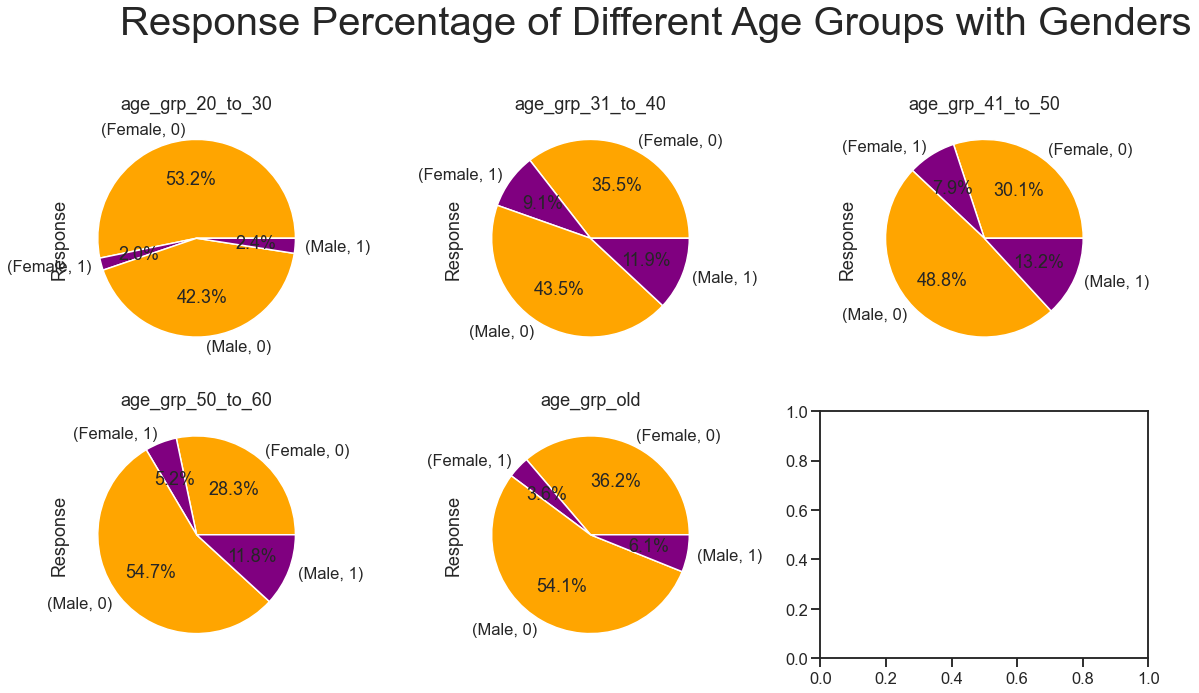

In [18]:
f,ax = plt.subplots(nrows=2, ncols=3, figsize = (20,10))
axx = ax.flatten()
plt.title('Response Percentage of Different Age Groups with Genders',fontsize=40,x=-0.5,y=2.5)
for pos,tup in enumerate(age_grp_dict.items()):
    axx[pos].set_title(tup[0])
    temp = tup[1]
    temp.groupby('Gender')['Response'].value_counts().plot.pie(autopct='%1.1f%%', ax = axx[pos],colors=['Orange','Purple'])

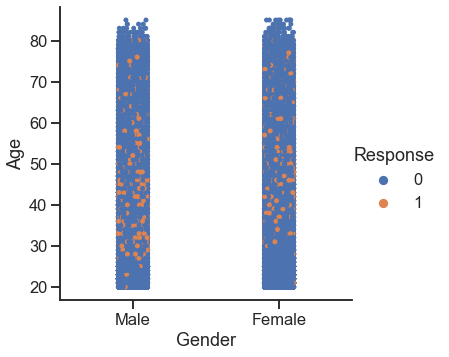

In [19]:
sns.catplot(x = 'Gender', y="Age",hue = 'Response', data=train)

## Insights:

1. Customers of age between 30 to 60 are more likely to buy insurance.
2. Customes of age between 20 to 30 are less likely to buy insurance.
3. In almost every age group, 'Male's are more likely to buy insurance.
4. Females under age 30 are very less likely ho buy insurance

---
## 3. Driving_License

<AxesSubplot:ylabel='Driving_License'>

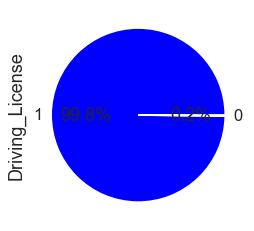

In [20]:
train['Driving_License'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'])

<AxesSubplot:title={'center':'Driving_Licence = 0'}, ylabel='Response'>

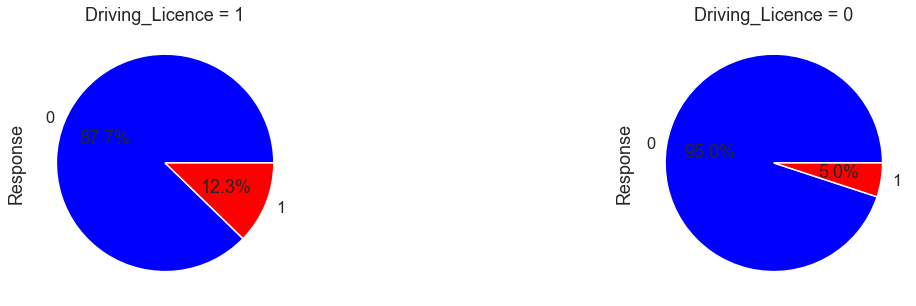

In [21]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize = (20,5))
axx = ax.flatten()
#plt.title('Driving_License wise Response',fontsize=40,x=-0.5,y=2)
axx[0].set_title('Driving_Licence = 1')
axx[1].set_title('Driving_Licence = 0')
train[ train['Driving_License'] == 1]['Response'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[0])
train[ train['Driving_License'] == 0]['Response'].value_counts().plot.pie(autopct='%1.1f%%',colors = ['Blue','Red'],ax=axx[1])

### Insights:

1. Very few customers don't have Driving License.
2. Customers with Driving License have higher chance of buying Insurance

---
## 4. Region_Code

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Region Wise Response Count'}, xlabel='Region_Code', ylabel='count'>

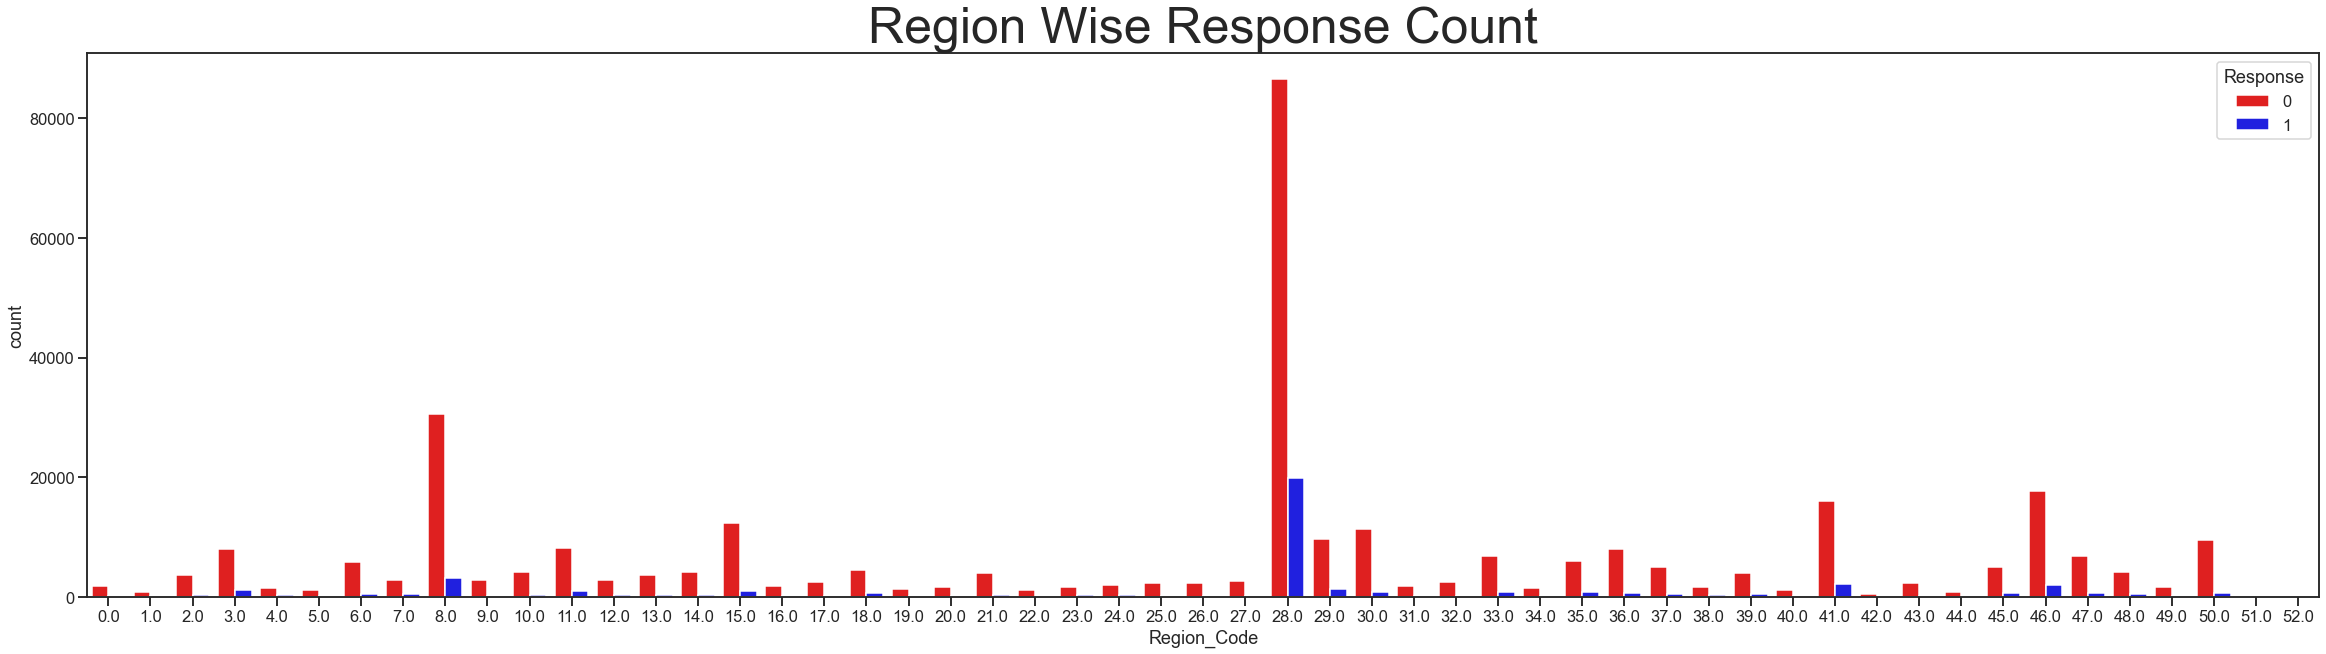

In [22]:
plt.figure(figsize = (40,10))
plt.title('Region Wise Response Count',fontsize=50)
sns.countplot(train['Region_Code'], hue = train['Response'],palette=['Red','Blue'])

### Visualizing Percentage of Response : 1 in all Region_Codes

In [23]:
u_region = train['Region_Code'].unique()
region_perc = {}
for i in u_region:
    total_region = train[ train['Region_Code'] == i].shape[0]
    buy_region = train[ (train['Region_Code'] == i) & train['Response'] == 1].shape[0]
    region_perc[i] = (buy_region/total_region)*100

region_perc = sorted(region_perc.items(), key=lambda x: x[1], reverse=True)
region_perc = list(zip(*region_perc))

region = np.array(region_perc[0])
region_perc = np.array(region_perc[1])
region = pd.DataFrame(region)
region_perc = pd.DataFrame(region_perc)

region_res_perc = pd.concat((region,region_perc), axis=1)
region_res_perc.columns = ['Region_Code', 'Buy_Percentage']

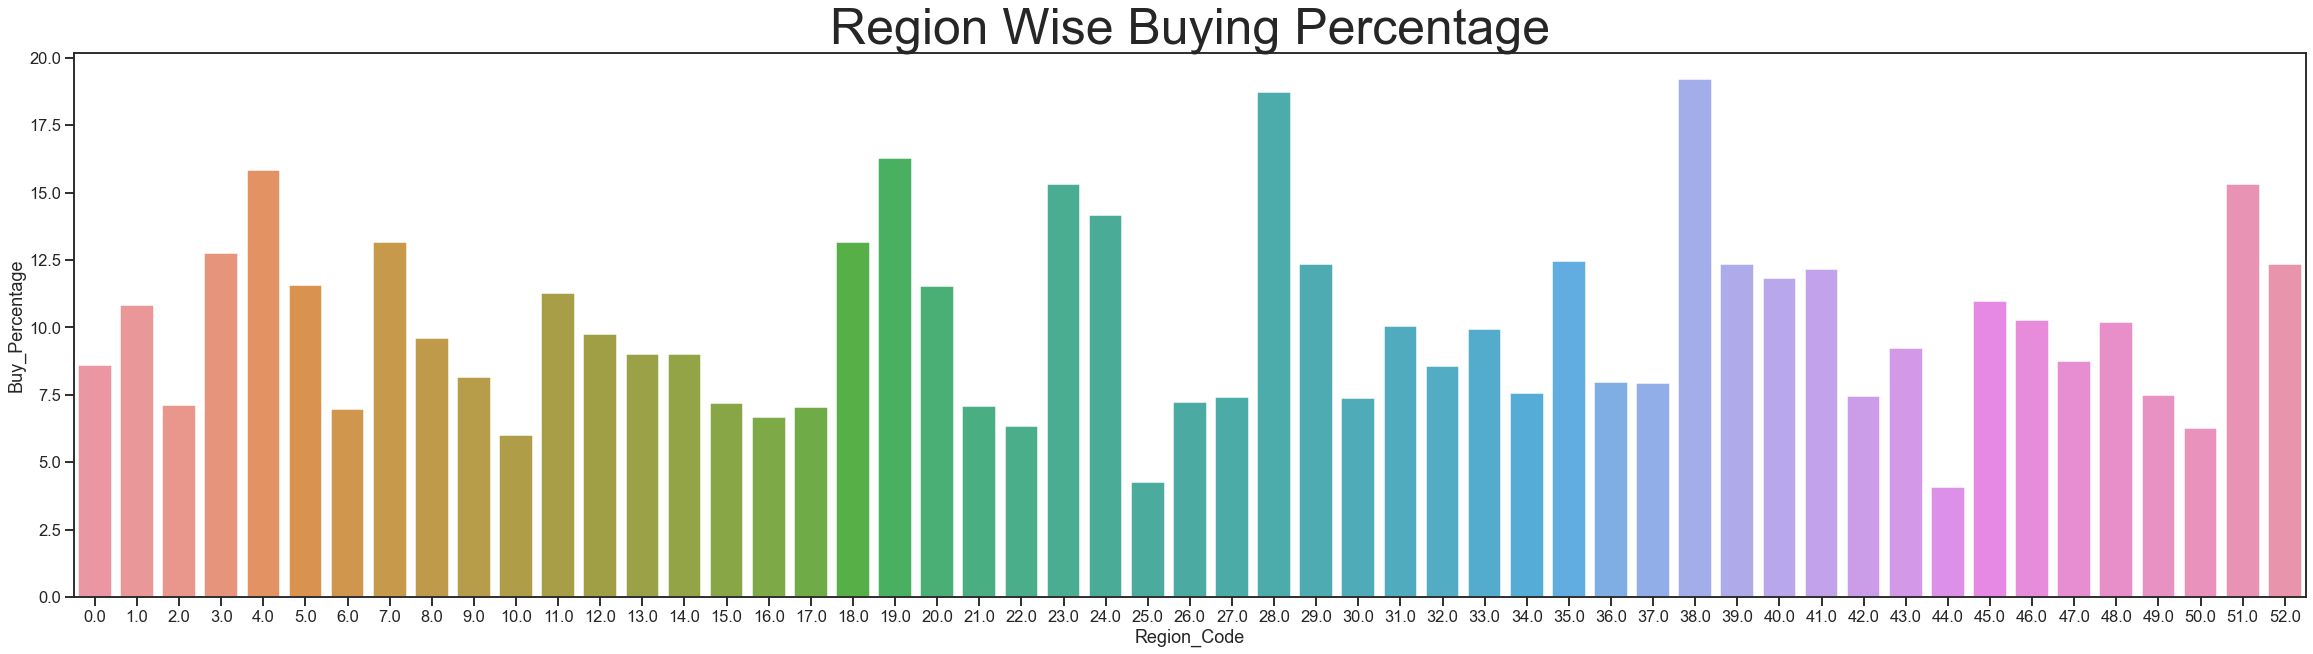

In [24]:
plt.figure(figsize=(40,10))
plt.title('Region Wise Buying Percentage',fontsize=50)
ax = sns.barplot(x = region_res_perc['Region_Code'], y = region_res_perc['Buy_Percentage'])

### Insights:

1. We have most of the customers from Region_Code : 28.
2. Region_Codes: [4,19,23,24,,28,38,51] have higher percentage of buying insurance.
3. Region_Codes: 25 and 44 have lower percentage of buying insurance.

---
## 5. Previously_Insuaranced

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

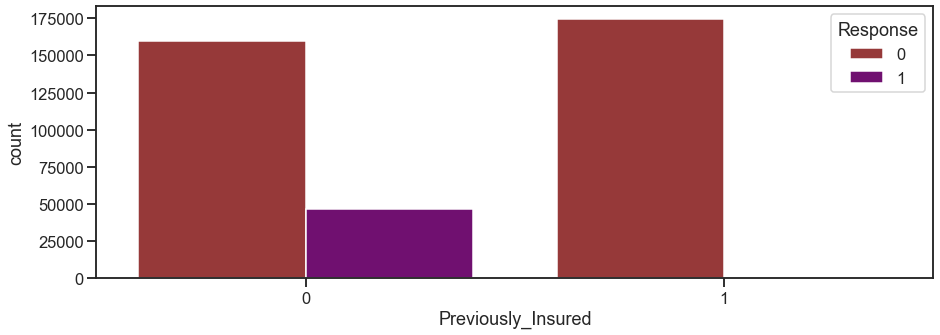

In [25]:
plt.figure(figsize=(15,5))
sns.countplot(train['Previously_Insured'],hue=train['Response'],palette=['Brown','Purple'])

### Insights:

1. Customers who Previously_Insured are very likely to buy Insurnce now.
2. Customers who didn't Previously_Insured have good chance of buying Insurnce.

---
## 6. Vehicle_Age

<AxesSubplot:ylabel='Vehicle_Age'>

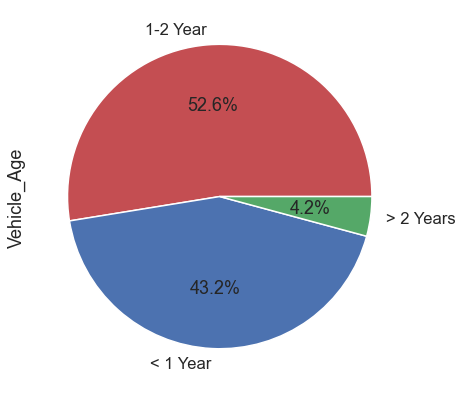

In [26]:
plt.figure(figsize=(7,7))
train['Vehicle_Age'].value_counts().plot.pie(autopct='%1.1f%%', colors = ['r', 'b', 'g'])

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vehicle_Age', ylabel='count'>

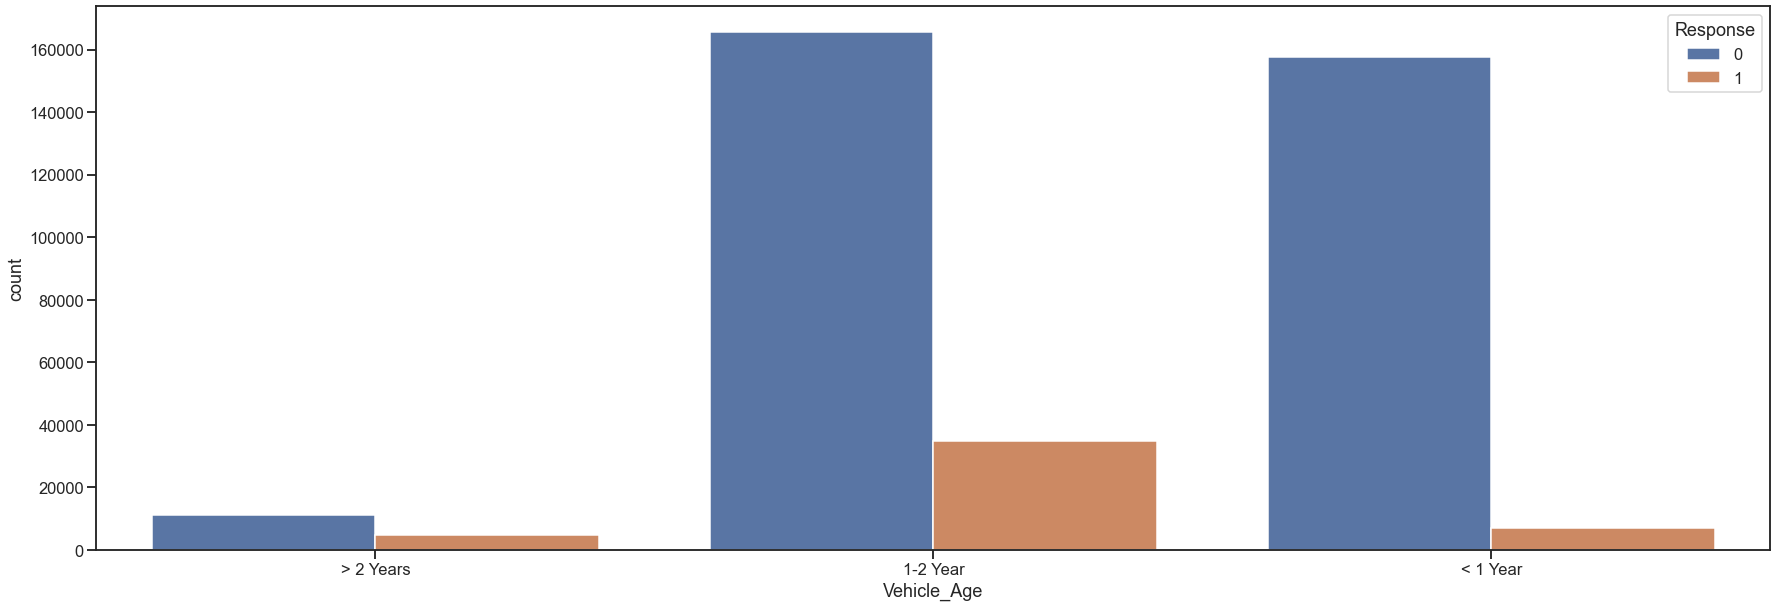

In [27]:
plt.figure(figsize = (30,10))
sns.countplot(train['Vehicle_Age'], hue = train['Response'])

In [28]:
ls = train['Vehicle_Age'].unique()

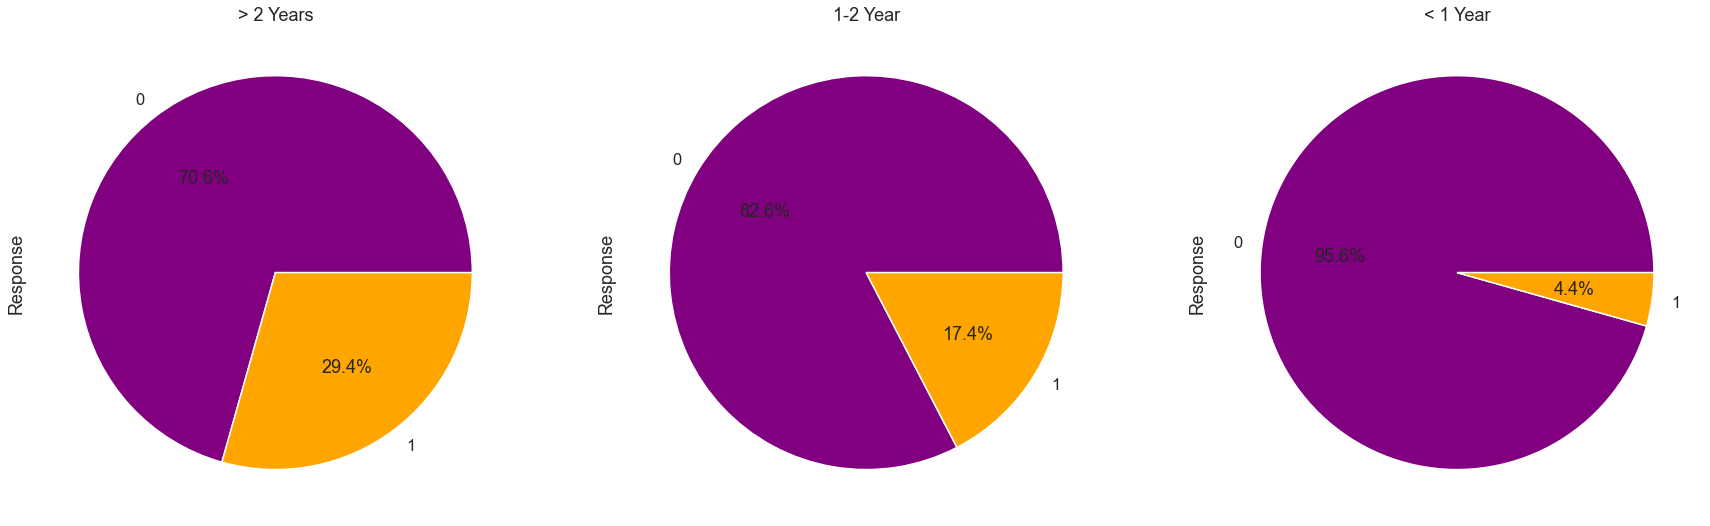

In [29]:
f,ax = plt.subplots(nrows=1, ncols=3,figsize = (30,10))
axx = ax.flatten()
for pos,val in enumerate(ls):
    axx[pos].set_title(str(val))
    train[ train['Vehicle_Age'] == val]['Response'].value_counts().plot.pie(autopct = '%1.1f%%',ax = axx[pos], colors=['Purple', 'Orange'])

### Insights :

1. We have half of our customers with Vehicle_Age `1-2 years`.
2. We have very few customers (4.2%) with Vehicle_Age `>2 years.
3. Customers with Vehicle_Age `>2years` have better chance (29.4%) of buying Insurance.
4. Customers with with Vehicle_Age `<1 years` have very less chance of buying Insurance.

---
## 7. Vehicle_Damage

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vehicle_Damage', ylabel='count'>

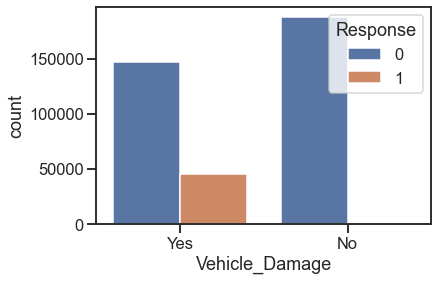

In [30]:
sns.countplot(train['Vehicle_Damage'], hue = train['Response'])

### Insights:

1. We have almost same number of customes with damaged and non_damaged vehicle.
2. Customers with Vehicle_Damage are likely to buy insurance.
3. Customers with non damaged vehicle have least chance (less than 1%) of buying insurance.

---
## 8. Annual_Premium

C:\Users\archa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Annual_Premium'>

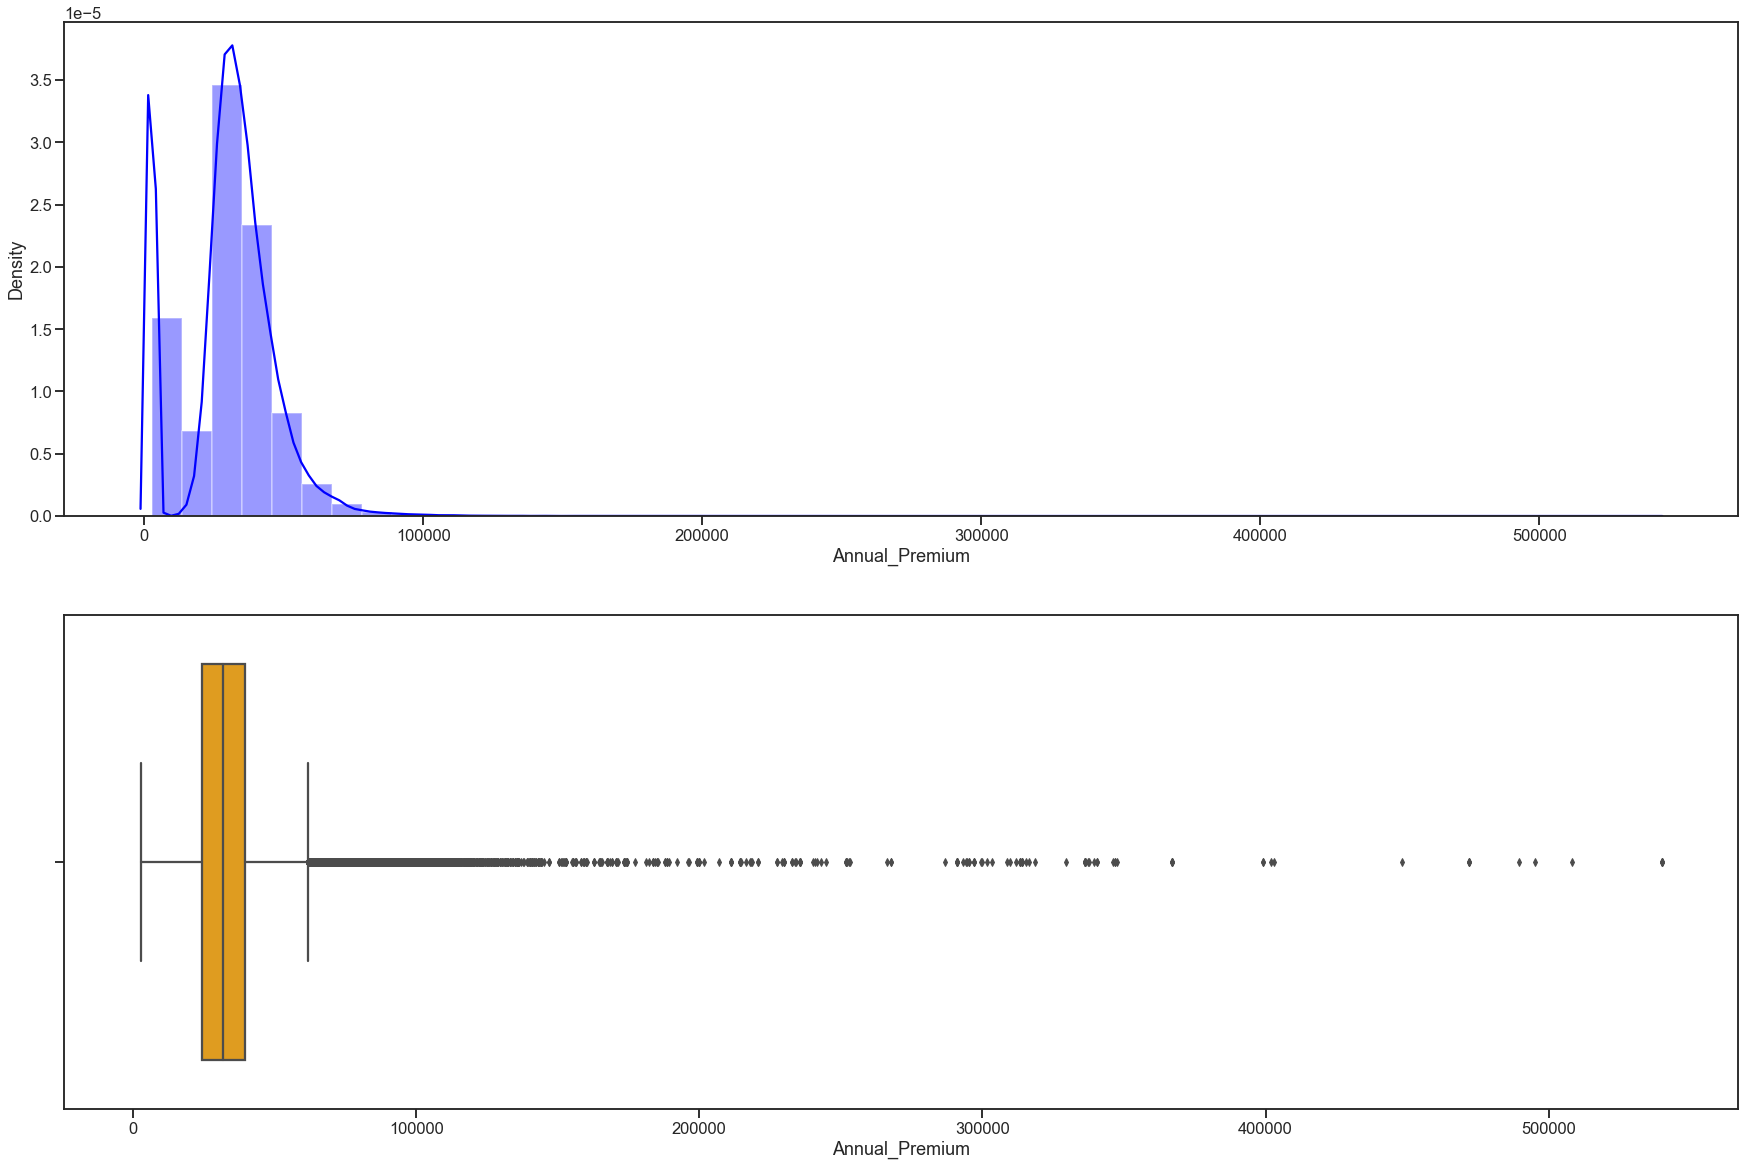

In [31]:
f,ax = plt.subplots(nrows=2,ncols=1,figsize=(30,20))
axx = ax.flatten()
#plt.figure(figsize=(30,10))
sns.distplot(train['Annual_Premium'],ax=axx[0], color='Blue')
sns.boxplot(train['Annual_Premium'],ax=axx[1],color='Orange')

C:\Users\archa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

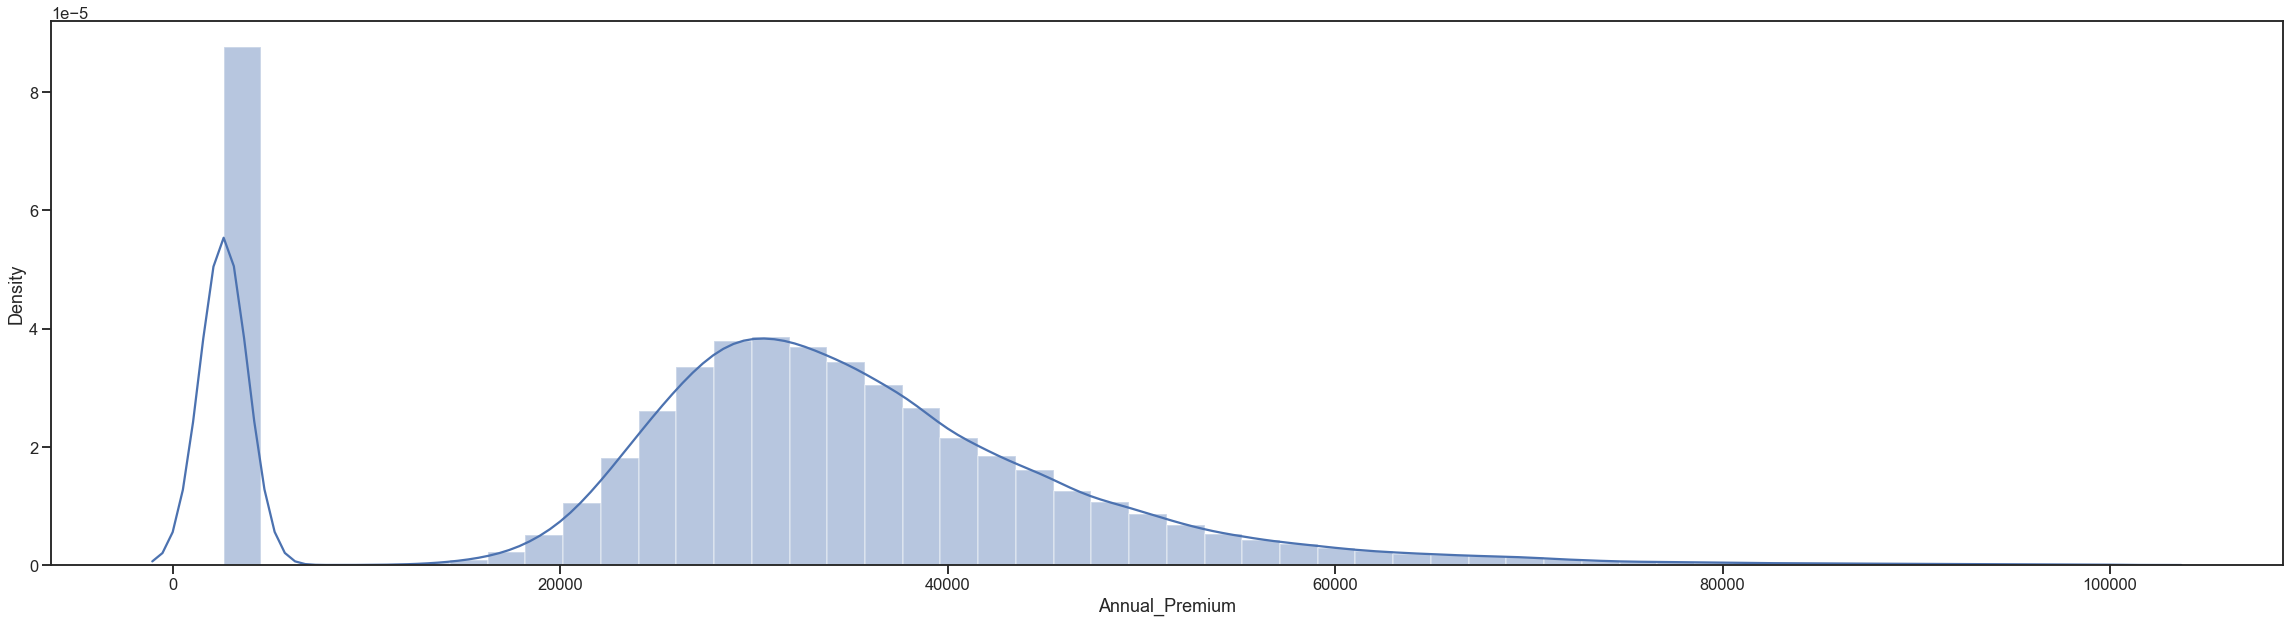

In [32]:
plt.figure(figsize=(40,10))
sns.distplot(train[ train['Annual_Premium'] < 100000]['Annual_Premium'])#.plot.hist(bins = 500, frequency=(0,10000))

In [33]:
start = 0
step = 10000
ls = []
for _ in range(10):
    ls.append((start,step))
    start = step
    step+=10000

for tup in ls:
    count = train[ train['Annual_Premium'].between(tup[0],tup[1])].shape[0]
    percentage = train[ (train['Annual_Premium'].between(tup[0], tup[1])) & (train['Response'] == 1)].shape[0]/train[ train['Annual_Premium'].between(tup[0], tup[1])].shape[0]*100
    print('Number of Customers with Annual_Premium Between {} : {} and Insurance Buy Percentage:{}'.format(tup,count,percentage))

Number of Customers with Annual_Premium Between (0, 10000) : 64882 and Insurance Buy Percentage:13.109953453962579
Number of Customers with Annual_Premium Between (10000, 20000) : 5803 and Insurance Buy Percentage:7.858004480441151
Number of Customers with Annual_Premium Between (20000, 30000) : 95393 and Insurance Buy Percentage:10.03742412965312
Number of Customers with Annual_Premium Between (30000, 40000) : 125062 and Insurance Buy Percentage:11.992451743935009
Number of Customers with Annual_Premium Between (40000, 50000) : 57793 and Insurance Buy Percentage:14.32699461872545
Number of Customers with Annual_Premium Between (50000, 60000) : 20050 and Insurance Buy Percentage:15.261845386533665
Number of Customers with Annual_Premium Between (60000, 70000) : 7271 and Insurance Buy Percentage:15.334892036858754
Number of Customers with Annual_Premium Between (70000, 80000) : 2524 and Insurance Buy Percentage:14.183835182250396
Number of Customers with Annual_Premium Between (80000, 9

### Insights:

1. 'Annual Premium' data is highlt left skewed.
2. Most of the customers have "Annual_Premium' in range (0, 10000) and (20000 to 50000)
3. In every 'Annual Premium' range, the insurance buy percentage is almost same.

---
## 9. Plolicy_Sales_Channel

<AxesSubplot:>

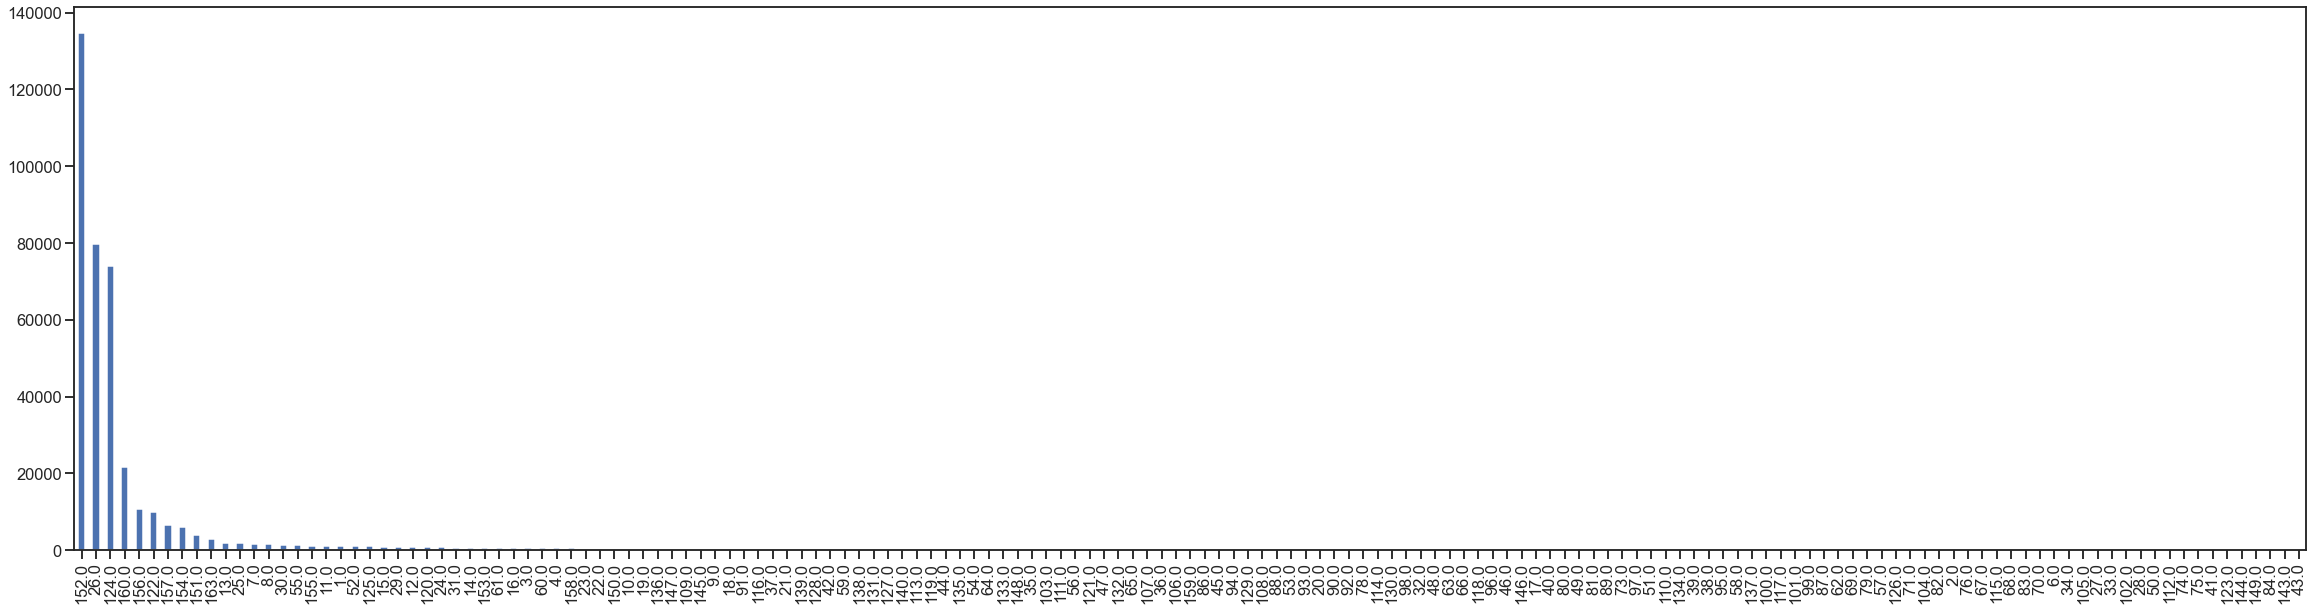

In [34]:
plt.figure(figsize=(40,10))
train['Policy_Sales_Channel'].value_counts().plot.bar()

### Insights:

1. Policy_Sales_Channel no. 152 have higest number of customers.
2. Policy_Sales_Channel no. [152,26,124,160,156,122,157,154,151,163] have most of the customers.

---
## 10. Vintage

C:\Users\archa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Vintage'>

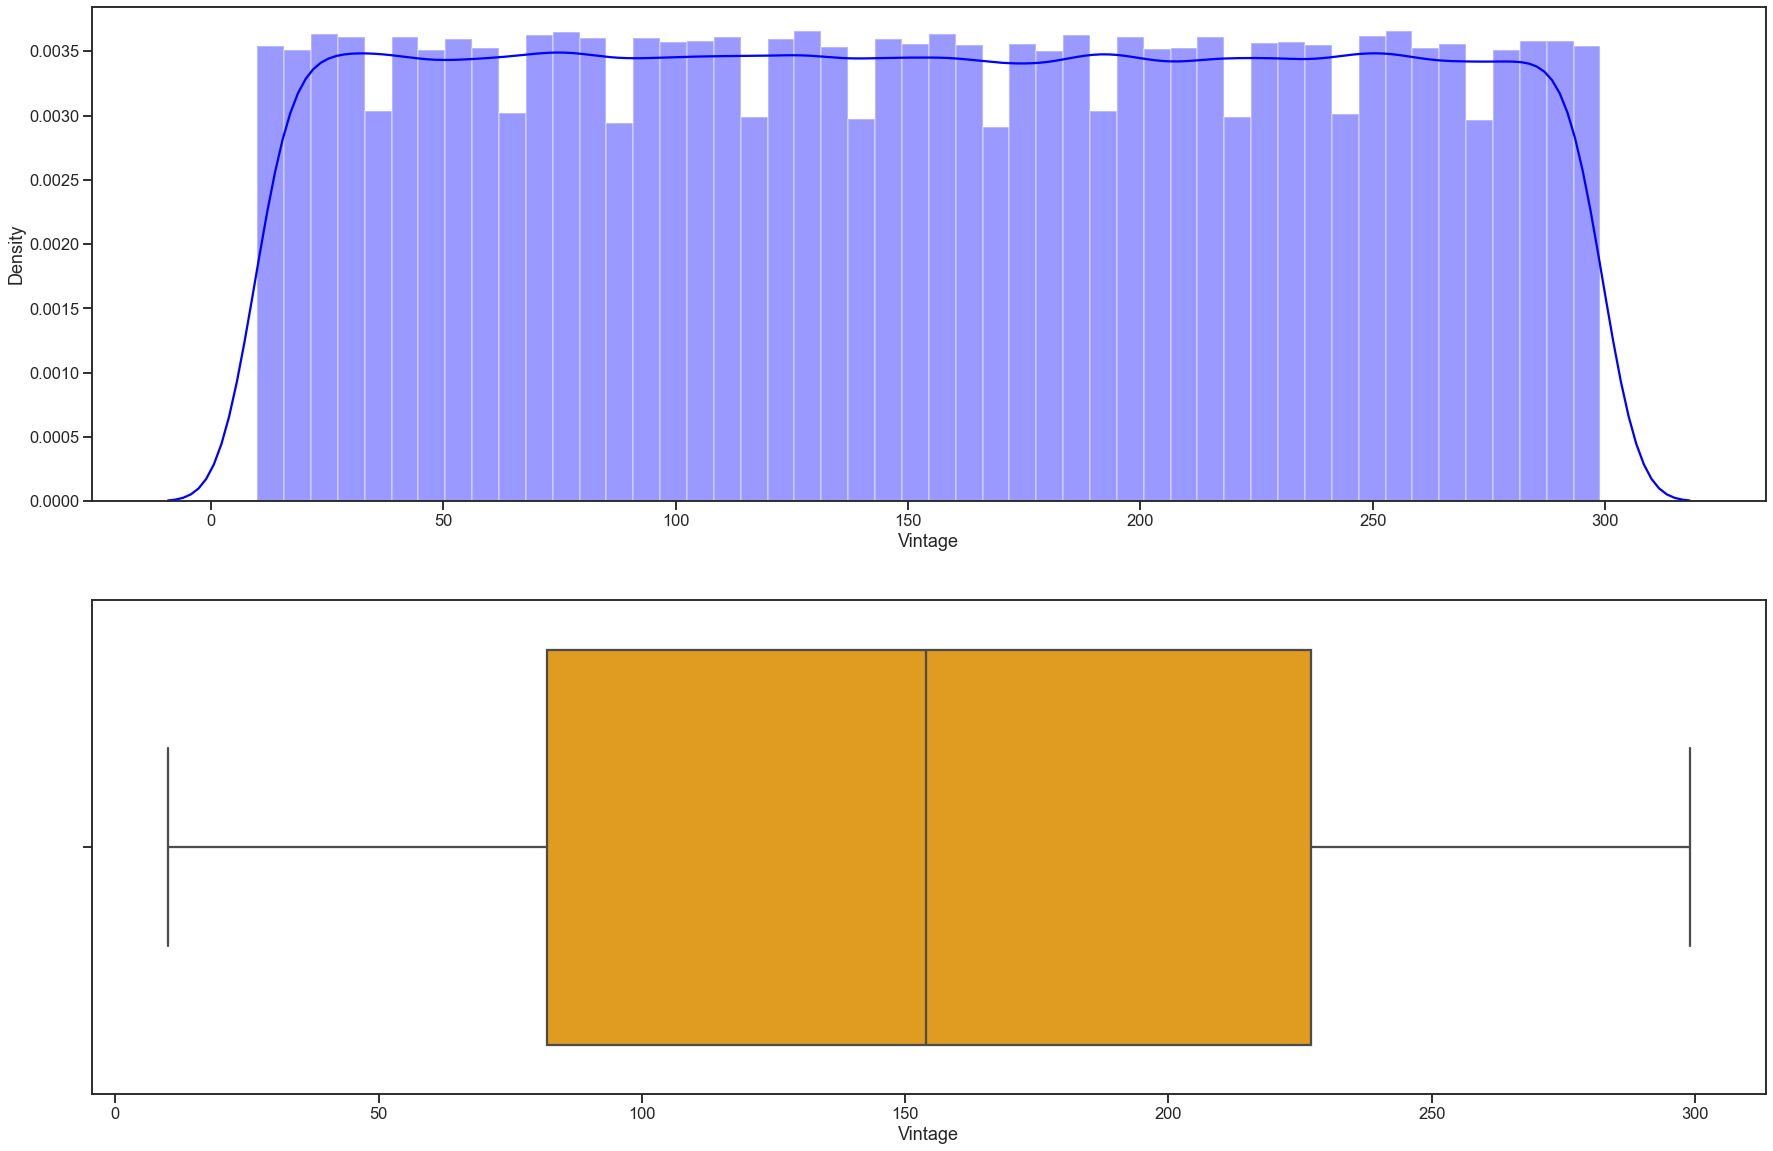

In [35]:
f,ax = plt.subplots(nrows=2,ncols=1,figsize=(30,20))
axx = ax.flatten()
sns.distplot(train['Vintage'],ax=axx[0], color='Blue')
sns.boxplot(train['Vintage'],ax=axx[1],color='Orange')

### Insights:

1. Every 'Vintage' value have almost same number of customers.

---
# Everything at Once.

### All Insights From Variable Analysis



1. Customers of age between 30 to 60 are more likely to buy insurance.
2. Customes of age between 20 to 30 are less likely to buy insurance.
3. In almost every age group, 'Male's are more likely to buy insurance.
4. Females under age 30 are very less likely ho buy insurance.
5. Very few customers don't have Driving License.
6. Customers with Driving License have higher chance of buying Insurance.
7. We have most of the customers from Region_Code : 28.
8. Region_Codes: [4,19,23,24,,28,38,51] have higher percentage of buying insurance.
9. Region_Codes: 25 and 44 have lower percentage of buying insurance.
10. Customers who Previously_Insured are very likely to buy Insurnce now.
11. Customers who didn't Previously_Insured have good chance of buying Insurnce.
12. We have half of our customers with Vehicle_Age 1-2 years.
13. We have very few customers (4.2%) with Vehicle_Age >2 years.
14. Customers with Vehicle_Age >2years have better chance (29.4%) of buying Insurance.
15. Customers with with Vehicle_Age <1 years have very less chance of buying Insurance.
16. We have almost same number of customes with damaged and non_damaged vehicle.
17. Customers with Vehicle_Damage are likely to buy insurance.
18. Customers with non damaged vehicle have least chance (less than 1%) of buying insurance.
19. 'Annual Premium' data is highlt left skewed.
20. Most of the customers have "Annual_Premium' in range (0, 10000) and (20000 to 50000)
21. In every 'Annual Premium' range, the insurance buy percentage is almost same.
22. Policy_Sales_Channel no. 152 have higest number of customers.
23. Policy_Sales_Channel no. [152,26,124,160,156,122,157,154,151,163] have most of the customers.
24. Every 'Vintage' value have almost same number of customers.



---
# Merging Train and Test Data

In [36]:
train['is_train'] = 1
test['is_train'] = 0
test['Response'] = None

data = pd.concat((train,test))
data.set_index('id',inplace=True)
data.shape

(508146, 12)

---
# Outlier Analysis

## 1. Age

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\archa\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='Age'>

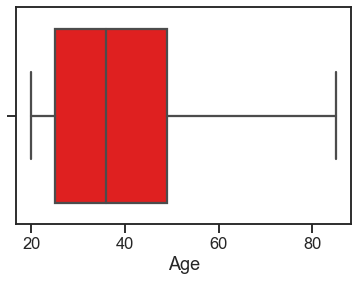

In [37]:
sns.boxplot('Age', data=data, orient='v', color='Red')

## 2. Annual_Premium

C:\Users\archa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\archa\anaconda3\lib\site-packages\seaborn\_core.py:1303: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


<AxesSubplot:xlabel='Annual_Premium'>

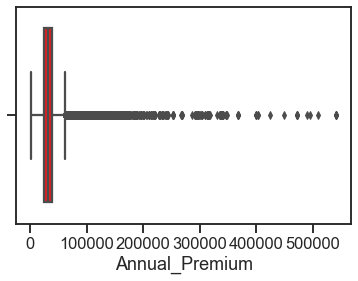

In [38]:
sns.boxplot('Annual_Premium', data=data,orient='v', color='red')

<AxesSubplot:xlabel='Annual_Premium', ylabel='Density'>

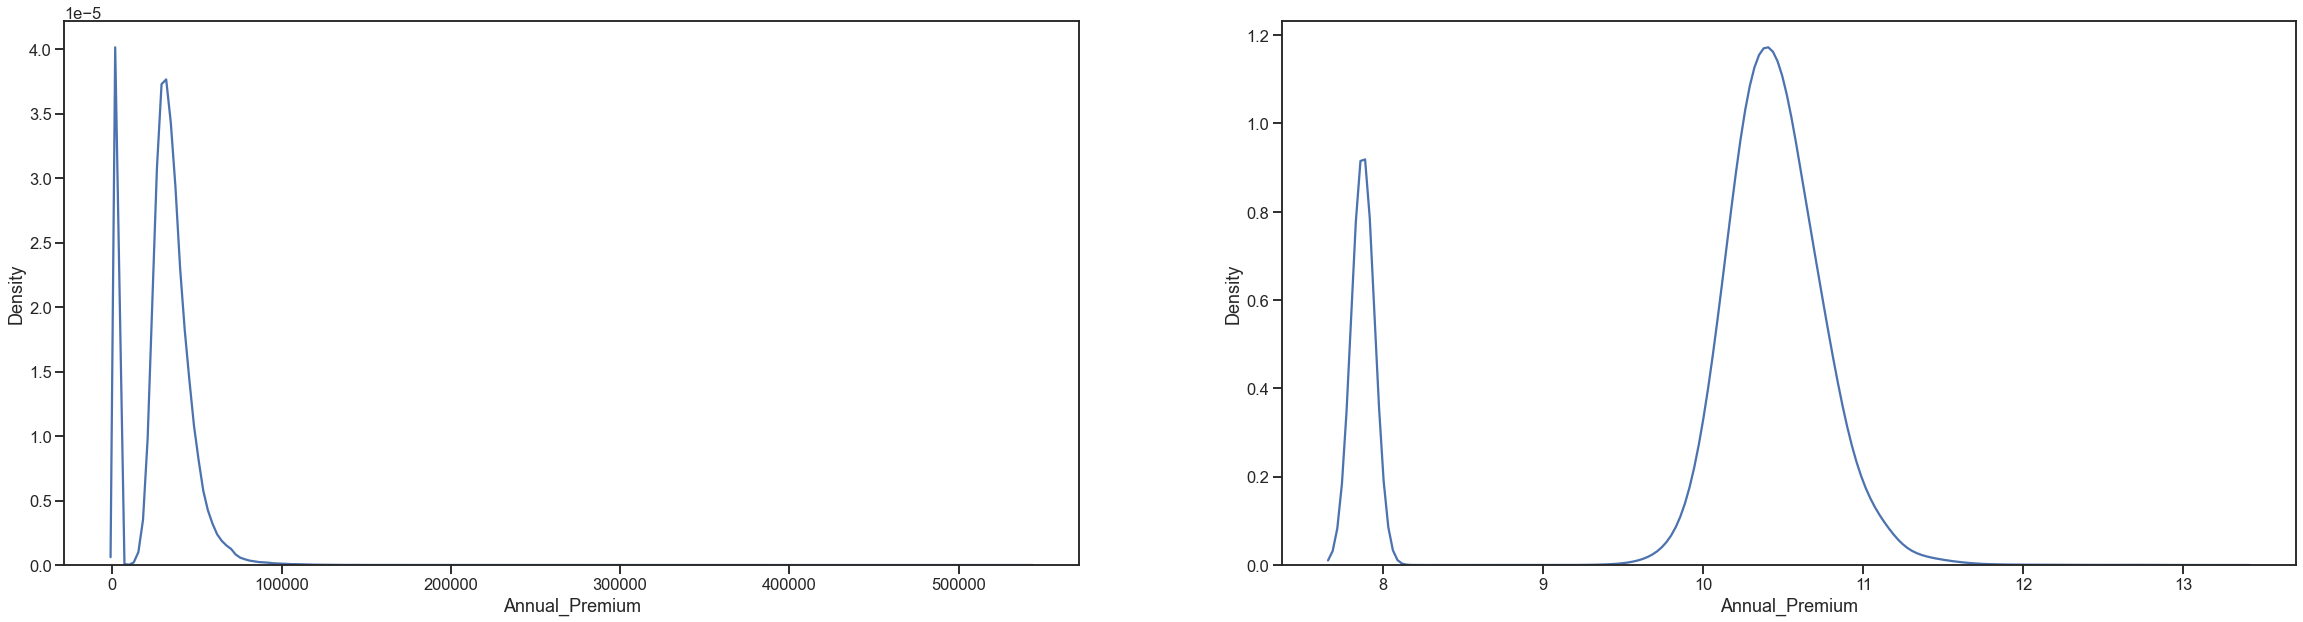

In [39]:
f,ax = plt.subplots(nrows=1,ncols=2,figsize = (40,10))
axx = ax.flatten()
sns.kdeplot(data['Annual_Premium'], legend=False,ax = axx[0])
sns.kdeplot(np.log(data['Annual_Premium']), legend=False,ax = axx[1]) # after using log transformation

### we will do log transformation on 'Annual_Premium'

---
# Corelation Analysis

### Label Encoding for co-relation checking

In [40]:
corr_check = data.copy()

col_ls = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

for col in col_ls:
    corr_check[col] = le.fit_transform(corr_check[col])

<AxesSubplot:>

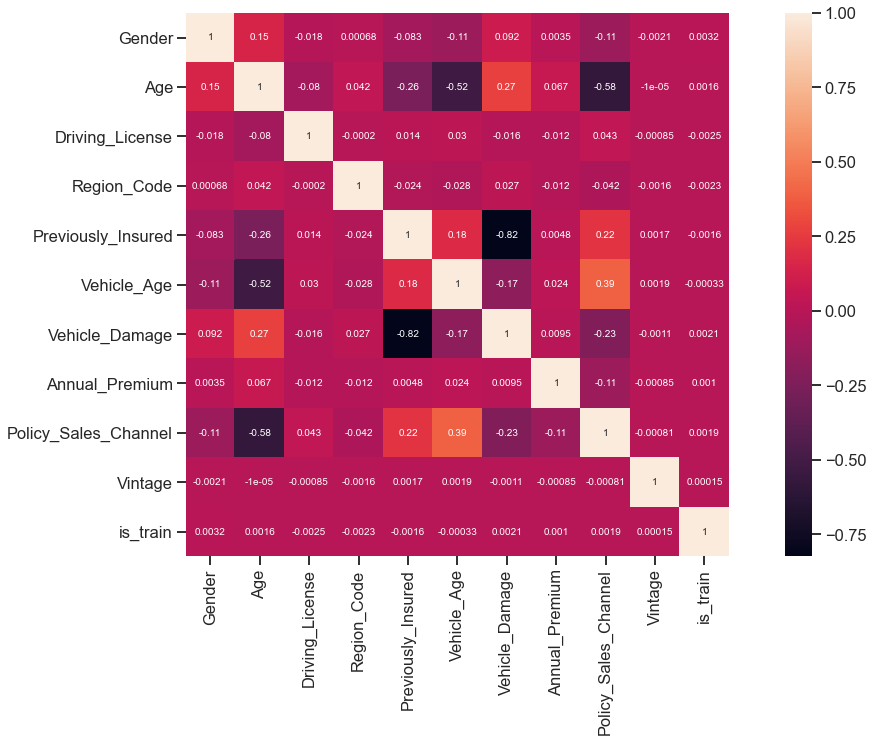

In [41]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_check.corr(), annot=True, square=True,annot_kws={'size': 10})

## Insights: 

1. 'Previously_Insured'  and 'Vehicle_Damage' are highly positively corelated.
2. 'Age' and 'Policy_Sales_Channel' are negatively corelated.
3. 'Age' and 'Vehicle_Age' are negatively corelated.

---
# Data Preprocessing

In [42]:
train['Vehicle_Age']=train['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
train['Gender']=train['Gender'].replace({'Male':1,'Female':0})
train['Vehicle_Damage']=train['Vehicle_Damage'].replace({'Yes':1,'No':0})

test['Vehicle_Age']=test['Vehicle_Age'].replace({'< 1 Year':0,'1-2 Year':1,'> 2 Years':2})
test['Gender']=test['Gender'].replace({'Male':1,'Female':0})
test['Vehicle_Damage']=test['Vehicle_Damage'].replace({'Yes':1,'No':0})

In [43]:
# Changing Datatype
train['Region_Code']=train['Region_Code'].astype(int)
test['Region_Code']=test['Region_Code'].astype(int)
train['Policy_Sales_Channel']=train['Policy_Sales_Channel'].astype(int)
test['Policy_Sales_Channel']=test['Policy_Sales_Channel'].astype(int)

---
# Model Building

In [44]:
features=['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']

cat_col=['Gender','Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage','Policy_Sales_Channel']

---
## Train Test Split

In [45]:
X=train[features]
y=train['Response']

In [46]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=150303,stratify=y,shuffle=True)

## 1. CatBoost Model

In [47]:
catb = CatBoostClassifier()
catb= catb.fit(X_train, y_train,cat_features=cat_col,eval_set=(X_test, y_test),early_stopping_rounds=30,verbose=100)
y_pred = catb.predict(X_test)
proba = catb.predict_proba(X_test)[:, 1]
print('CatBoost Base Accuracy : {}'.format(accuracy_score(y_test,y_pred)))
print('CatBoost Base ROC_AUC_SCORE: {}'.format(roc_auc_score(y_test,proba)))

Learning rate set to 0.128106
0:	learn: 0.4910032	test: 0.4914047	best: 0.4914047 (0)	total: 395ms	remaining: 6m 34s
100:	learn: 0.2632019	test: 0.2644836	best: 0.2644836 (100)	total: 18.5s	remaining: 2m 45s
200:	learn: 0.2614128	test: 0.2643219	best: 0.2643075 (176)	total: 38.2s	remaining: 2m 31s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.2643015576
bestIteration = 205

Shrink model to first 206 iterations.
CatBoost Base Accuracy : 0.8775792942756985
CatBoost Base ROC_AUC_SCORE: 0.8585933053277295


## 2. LGBM Model

In [48]:
model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
proba = model.predict_proba(X_test)[:,1]

In [49]:
print('LGBM Base Accuracy : {}'.format(accuracy_score(y_test,y_pred)))
print('LGBM Base ROC_AUC_SCORE: {}'.format(roc_auc_score(y_test,proba)))

LGBM Base Accuracy : 0.8771489745796511
LGBM Base ROC_AUC_SCORE: 0.8571310697700907


## Hyperparameter Tuning LGBM

In [50]:
def create_model(trial):
    max_depth = trial.suggest_int("max_depth", 2, 30)
    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    learning_rate = trial.suggest_uniform('learning_rate', 0.0000001, 1)
    num_leaves = trial.suggest_int("num_leaves", 2, 5000)
    min_child_samples = trial.suggest_int('min_child_samples', 3, 200)
    reg_alpha = trial.suggest_int("reg_alpha", 1, 10)
    reg_lambda = trial.suggest_int("reg_lambda", 1, 10)
    model = LGBMClassifier(
        learning_rate=learning_rate, 
        n_estimators=n_estimators, 
        max_depth=max_depth,
        num_leaves=num_leaves, 
        min_child_samples=min_child_samples,
        random_state=0
    )
    return model

sampler = TPESampler(seed=0)
def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train)
    proba = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test,proba)
    return score

study = optuna.create_study(direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=50)

lgb_params = study.best_params
lgb_params['random_state'] = 0
lgb = LGBMClassifier(**lgb_params)
lgb.fit(X_train, y_train)
proba = lgb.predict_proba(X_test)[:,1]
print('Optimized LightGBM roc_auc_score', roc_auc_score(y_test, proba))

[I 2021-02-03 12:19:28,349] A new study created in memory with name: no-name-de4d3998-8f21-456c-88f5-8d4c54123bb1
[I 2021-02-03 12:19:31,526] Trial 0 finished with value: 0.8384403887692967 and parameters: {'max_depth': 14, 'n_estimators': 48, 'learning_rate': 0.7151893948534829, 'num_leaves': 4933, 'min_child_samples': 198, 'reg_alpha': 8, 'reg_lambda': 10}. Best is trial 0 with value: 0.8384403887692967.
[I 2021-02-03 12:20:03,857] Trial 1 finished with value: 0.8306063777962243 and parameters: {'max_depth': 21, 'n_estimators': 278, 'learning_rate': 0.3843817688545291, 'num_leaves': 3470, 'min_child_samples': 61, 'reg_alpha': 2, 'reg_lambda': 7}. Best is trial 0 with value: 0.8384403887692967.
[I 2021-02-03 12:20:06,000] Trial 2 finished with value: 0.8470257599043227 and parameters: {'max_depth': 9, 'n_estimators': 88, 'learning_rate': 0.47997722437734014, 'num_leaves': 2899, 'min_child_samples': 168, 'reg_alpha': 10, 'reg_lambda': 9}. Best is trial 2 with value: 0.8470257599043227.

[I 2021-02-03 12:24:54,435] Trial 27 finished with value: 0.8436023560024943 and parameters: {'max_depth': 7, 'n_estimators': 263, 'learning_rate': 0.42414049362763834, 'num_leaves': 4237, 'min_child_samples': 90, 'reg_alpha': 3, 'reg_lambda': 3}. Best is trial 12 with value: 0.8585575594644492.
[I 2021-02-03 12:25:10,601] Trial 28 finished with value: 0.8456373248352319 and parameters: {'max_depth': 13, 'n_estimators': 495, 'learning_rate': 0.11532250584718914, 'num_leaves': 1359, 'min_child_samples': 183, 'reg_alpha': 2, 'reg_lambda': 5}. Best is trial 12 with value: 0.8585575594644492.
[I 2021-02-03 12:25:13,440] Trial 29 finished with value: 0.8573342100961117 and parameters: {'max_depth': 2, 'n_estimators': 389, 'learning_rate': 0.9328245039499701, 'num_leaves': 2332, 'min_child_samples': 137, 'reg_alpha': 4, 'reg_lambda': 2}. Best is trial 12 with value: 0.8585575594644492.
[I 2021-02-03 12:25:29,237] Trial 30 finished with value: 0.8303902268691548 and parameters: {'max_depth': 

Optimized LightGBM roc_auc_score 0.8586155381730338


In [51]:
lgb

LGBMClassifier(learning_rate=0.24478963236865636, max_depth=2,
               min_child_samples=183, n_estimators=374, num_leaves=4574,
               random_state=0, reg_alpha=2, reg_lambda=3)

In [52]:
LGBM = lgb
LGBM.fit(X, y)
y_pred = LGBM.predict(X_test)
proba = LGBM.predict_proba(X_test)[:,1]

In [53]:
print('LGBM Tuned Accuracy : {}'.format(accuracy_score(y_test,y_pred)))
print('LGBM Tuned ROC_AUC_SCORE: {}'.format(roc_auc_score(y_test,proba)))

LGBM Tuned Accuracy : 0.877978127164718
LGBM Tuned ROC_AUC_SCORE: 0.8605447049660302
